# LightGCN V6 - Low-Rank Regularized GNN

## 핵심 아이디어: "High-Dimensional Data Analysis with Low-Dimensional Models" 적용

### 책의 Chapter 4 (Low-Rank Matrix Recovery) 개념 적용:
1. **SVD-based Initialization**: Rating matrix의 저랭크 구조를 반영한 초기화
2. **Nuclear Norm Regularization**: ||U||_F^2 + ||V||_F^2 정규화
3. **Incoherence Penalty**: 임베딩 벡터 간 직교성 유도
4. **Confidence Weighting**: User/Item activity 기반 신뢰도 가중치

### V5 대비 변경사항:
- 3-way split (Train/Valid/Test = 70/15/15)
- SVD spectrum 분석으로 최적 rank 탐색
- 저랭크 이론 기반 정규화 강화

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. 데이터 로딩 및 3-Way Split

In [2]:
# 데이터 로딩
df = pd.read_csv('../data/train.csv')

# User/Item 인덱싱
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)
df['label'] = (df['rating'] >= 4.0).astype(int)  # 4.0 이상만 positive

positive_df = df[df['label'] == 1].copy()

print(f"Total ratings: {len(df):,}")
print(f"Positive ratings (>= 4.0): {len(positive_df):,}")
print(f"Users: {n_users}, Items: {n_items}")
print(f"Sparsity: {100 * (1 - len(df) / (n_users * n_items)):.2f}%")

Total ratings: 105,139
Positive ratings (>= 4.0): 51,830
Users: 668, Items: 10321
Sparsity: 98.48%


In [3]:
# 3-Way Split: Train 70%, Valid 15%, Test 15%
# User별 stratified split (데이터 누수 방지)

train_data, val_data, test_data = [], [], []

for user_idx in range(n_users):
    user_pos = positive_df[positive_df['user_idx'] == user_idx]
    n_pos = len(user_pos)
    
    if n_pos >= 3:  # 최소 3개 이상이어야 3-way split 가능
        user_pos = user_pos.sample(frac=1, random_state=SEED).reset_index(drop=True)
        
        # 70 / 15 / 15 split
        train_end = int(0.7 * n_pos)
        val_end = int(0.85 * n_pos)
        
        # 최소 1개씩은 보장
        train_end = max(1, train_end)
        val_end = max(train_end + 1, val_end)
        
        train_data.append(user_pos.iloc[:train_end])
        val_data.append(user_pos.iloc[train_end:val_end])
        test_data.append(user_pos.iloc[val_end:])
        
    elif n_pos == 2:
        # 2개면 train 1개, val 1개
        user_pos = user_pos.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(user_pos.iloc[:1])
        val_data.append(user_pos.iloc[1:])
        
    elif n_pos == 1:
        # 1개면 train에만
        train_data.append(user_pos)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

print(f"3-Way Split:")
print(f"  Train: {len(train_df):,} ({100*len(train_df)/len(positive_df):.1f}%)")
print(f"  Valid: {len(val_df):,} ({100*len(val_df)/len(positive_df):.1f}%)")
print(f"  Test:  {len(test_df):,} ({100*len(test_df)/len(positive_df):.1f}%)")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df):,}")

3-Way Split:
  Train: 35,985 (69.4%)
  Valid: 7,754 (15.0%)
  Test:  8,091 (15.6%)
  Total: 51,830


In [4]:
# Tensor 변환
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)
val_users = torch.LongTensor(val_df['user_idx'].values)
val_items = torch.LongTensor(val_df['item_idx'].values)
test_users = torch.LongTensor(test_df['user_idx'].values)
test_items = torch.LongTensor(test_df['item_idx'].values)

# User별 positive items (train set 기준)
user_pos_items_train = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_pos_items_train[int(u)].add(int(i))

# Negative candidates (train set에 없는 items)
user_neg_candidates = {}
for u in range(n_users):
    pos = user_pos_items_train[u]
    user_neg_candidates[u] = np.array(list(set(range(n_items)) - pos))

print(f"Pre-computed negative candidates for {n_users} users")

Pre-computed negative candidates for 668 users


## 2. SVD Spectrum 분석 (책 Chapter 4.2)

Rating Matrix의 singular value 분포를 분석하여 최적의 embedding dimension (rank) 결정

In [5]:
# Sparse Rating Matrix 구성 (Train data 기준)
# Binary matrix: positive interaction만 1
row = train_df['user_idx'].values
col = train_df['item_idx'].values
data = np.ones(len(train_df))

R_sparse = csr_matrix((data, (row, col)), shape=(n_users, n_items))
print(f"Rating Matrix: {R_sparse.shape}")
print(f"Non-zeros: {R_sparse.nnz:,} ({100*R_sparse.nnz/(n_users*n_items):.4f}%)")

Rating Matrix: (668, 10321)
Non-zeros: 35,985 (0.5219%)


In [6]:
# Truncated SVD로 singular value spectrum 분석
# R ≈ U @ Σ @ V^T
k = min(100, min(n_users, n_items) - 1)  # Top k singular values

print(f"Computing top {k} singular values...")
U_svd, sigma, Vt_svd = svds(R_sparse.astype(np.float32), k=k)

# Sort by descending order (svds returns in ascending order)
idx = np.argsort(sigma)[::-1]
sigma = sigma[idx]
U_svd = U_svd[:, idx]
Vt_svd = Vt_svd[idx, :]

print(f"Top 10 singular values: {sigma[:10]}")
print(f"Largest: {sigma[0]:.2f}, Smallest: {sigma[-1]:.2f}")

Computing top 100 singular values...
Top 10 singular values: [62.629322 31.233122 26.96707  23.811813 23.177122 22.366383 21.729252
 20.929121 20.46429  19.835325]
Largest: 62.63, Smallest: 9.60


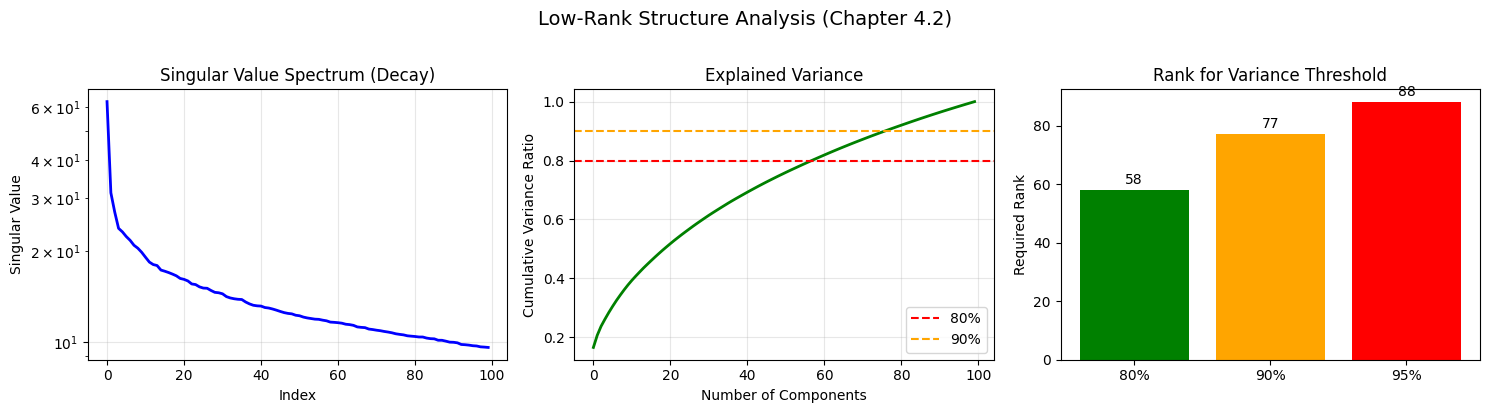


Optimal Rank Analysis:
  80% variance: rank 58
  90% variance: rank 77
  95% variance: rank 88

V5 used: emb_dim=32
Recommendation: Use emb_dim=64 for balance


In [7]:
# Explained variance ratio
total_variance = np.sum(sigma**2)
cumulative_variance = np.cumsum(sigma**2) / total_variance

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Singular Value Decay
axes[0].plot(sigma, 'b-', linewidth=2)
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Singular Value')
axes[0].set_title('Singular Value Spectrum (Decay)')
axes[0].grid(alpha=0.3)
axes[0].set_yscale('log')

# 2. Cumulative Variance
axes[1].plot(cumulative_variance, 'g-', linewidth=2)
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80%')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90%')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Ratio')
axes[1].set_title('Explained Variance')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Optimal Rank Selection
rank_80 = np.argmax(cumulative_variance >= 0.8) + 1
rank_90 = np.argmax(cumulative_variance >= 0.9) + 1
rank_95 = np.argmax(cumulative_variance >= 0.95) + 1

axes[2].bar(['80%', '90%', '95%'], [rank_80, rank_90, rank_95], color=['green', 'orange', 'red'])
axes[2].set_ylabel('Required Rank')
axes[2].set_title('Rank for Variance Threshold')
for i, v in enumerate([rank_80, rank_90, rank_95]):
    axes[2].text(i, v + 1, str(v), ha='center', va='bottom')

plt.suptitle('Low-Rank Structure Analysis (Chapter 4.2)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nOptimal Rank Analysis:")
print(f"  80% variance: rank {rank_80}")
print(f"  90% variance: rank {rank_90}")
print(f"  95% variance: rank {rank_95}")
print(f"\nV5 used: emb_dim=32")
print(f"Recommendation: Use emb_dim={min(64, rank_90)} for balance")

## 3. Graph 구성

In [8]:
def build_graph(train_df):
    """Bipartite graph with normalized adjacency"""
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    # User -> Item edges
    edge_u2i = np.array([users, items + n_users])
    # Item -> User edges
    edge_i2u = np.array([items + n_users, users])
    
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    # Symmetric normalization (D^{-1/2} A D^{-1/2})
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    edge_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    
    return edge_index.to(device), edge_weight.to(device)

edge_index, edge_weight = build_graph(train_df)
print(f"Graph: {edge_index.shape[1]:,} edges")

Graph: 71,970 edges


## 4. LightGCN with Low-Rank Regularization (책 Chapter 4.3, 4.4)

In [9]:
class LowRankLightGCN(nn.Module):
    """
    LightGCN with Low-Rank Theory Enhancements:
    1. SVD-based initialization (Chapter 4.2)
    2. Nuclear Norm regularization via Frobenius norm (Chapter 4.3)
    3. Incoherence penalty (Chapter 4.4.3)
    """
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=1, 
                 U_init=None, V_init=None):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        
        # SVD-based initialization
        if U_init is not None and V_init is not None:
            with torch.no_grad():
                self.user_emb.weight.copy_(torch.FloatTensor(U_init))
                self.item_emb.weight.copy_(torch.FloatTensor(V_init))
            print(f"Initialized with SVD (rank={emb_dim})")
        else:
            nn.init.xavier_uniform_(self.user_emb.weight)
            nn.init.xavier_uniform_(self.item_emb.weight)
            print(f"Initialized with Xavier uniform")
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]
    
    def nuclear_norm_reg(self):
        """
        Nuclear Norm Regularization (Chapter 4.3)
        ||W||_* ≈ ||U||_F^2 + ||V||_F^2 for low-rank factorization W ≈ UV^T
        """
        u_norm = torch.norm(self.user_emb.weight, p='fro') ** 2
        v_norm = torch.norm(self.item_emb.weight, p='fro') ** 2
        return (u_norm + v_norm) / 2
    
    def incoherence_penalty(self):
        """
        Incoherence Condition (Chapter 4.4.3)
        Encourage embedding vectors to be incoherent (spread out)
        Penalize when embeddings are too aligned (high dot product)
        """
        # Sample-based computation (for efficiency)
        n_sample = min(100, self.n_users)
        idx = torch.randperm(self.n_users)[:n_sample]
        U_sample = self.user_emb.weight[idx]  # [n_sample, emb_dim]
        
        # Normalize embeddings
        U_norm = F.normalize(U_sample, p=2, dim=1)
        
        # Gram matrix (similarity between all pairs)
        gram = torch.mm(U_norm, U_norm.t())  # [n_sample, n_sample]
        
        # Penalize off-diagonal elements (we want identity-like structure)
        # Remove diagonal
        mask = 1 - torch.eye(n_sample, device=gram.device)
        off_diag = gram * mask
        
        # Penalize high correlation
        penalty = torch.sum(off_diag ** 2) / (n_sample * (n_sample - 1))
        return penalty

In [10]:
# Model Configuration (V4 최적 설정)
EMB_DIM = 32  # V5와 동일
N_LAYERS = 1  # V4에서 최적으로 확인됨

# SVD 초기화 제거 - Xavier uniform이 GNN에 더 적합
# SVD는 matrix completion에는 좋지만, GNN의 graph structure learning과는 맞지 않음
print(f"Model Configuration:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  Initialization: Xavier uniform (not SVD)")

Model Configuration:
  emb_dim: 32
  n_layers: 1
  Initialization: Xavier uniform (not SVD)


In [11]:
# Model 생성 (Xavier uniform 초기화)
model = LowRankLightGCN(
    n_users, n_items, 
    emb_dim=EMB_DIM, 
    n_layers=N_LAYERS,
    U_init=None,  # SVD 초기화 제거
    V_init=None
).to(device)

print(f"\nModel Summary:")
print(f"  LowRankLightGCN: emb={EMB_DIM}, layers={N_LAYERS}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

Initialized with Xavier uniform

Model Summary:
  LowRankLightGCN: emb=32, layers=1
  Parameters: 351,648


## 5. Confidence-Weighted BPR Loss (책 Chapter 4.4.5)

In [12]:
# User/Item confidence 계산
# 많이 활동한 user/인기 item에 더 높은 신뢰도

user_activity = train_df.groupby('user_idx').size().values
item_popularity = train_df.groupby('item_idx').size().reindex(range(n_items), fill_value=0).values

# Log-scale confidence (급격한 차이 완화)
user_confidence = np.log1p(user_activity)
item_confidence = np.log1p(item_popularity)

# Normalize to [0.5, 1.5] range
user_confidence = 0.5 + (user_confidence - user_confidence.min()) / (user_confidence.max() - user_confidence.min())
item_confidence = 0.5 + (item_confidence - item_confidence.min()) / (item_confidence.max() - item_confidence.min() + 1e-8)

user_conf_tensor = torch.FloatTensor(user_confidence).to(device)
item_conf_tensor = torch.FloatTensor(item_confidence).to(device)

print(f"User confidence: min={user_confidence.min():.3f}, max={user_confidence.max():.3f}")
print(f"Item confidence: min={item_confidence.min():.3f}, max={item_confidence.max():.3f}")

User confidence: min=0.500, max=1.500
Item confidence: min=0.500, max=1.500


In [13]:
def confidence_weighted_bpr_loss(pos_scores, neg_scores, user_ids, pos_item_ids):
    """
    Confidence-Weighted BPR Loss (Chapter 4.4.5 - Stable Matrix Completion)
    
    Weight each sample by confidence based on user activity and item popularity.
    """
    # Confidence = user_conf * item_conf
    confidence = user_conf_tensor[user_ids] * item_conf_tensor[pos_item_ids]
    
    # BPR loss with confidence weighting
    diff = pos_scores.unsqueeze(1) - neg_scores  # [batch, num_neg]
    bpr = -torch.log(torch.sigmoid(diff) + 1e-8).mean(dim=1)  # [batch]
    
    # Weighted mean
    weighted_loss = (bpr * confidence).sum() / confidence.sum()
    return weighted_loss

## 6. 평가 함수

In [14]:
@torch.no_grad()
def evaluate(model, eval_users, eval_items, k=10, n_neg=99, sample_size=None):
    """
    Evaluate on given user-item pairs.
    Sample-based ranking: 1 positive + n_neg negatives
    """
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight)
    
    if sample_size and len(eval_users) > sample_size:
        sample_idx = np.random.choice(len(eval_users), sample_size, replace=False)
    else:
        sample_idx = np.arange(len(eval_users))
    
    hits, ndcgs = [], []
    
    for idx in sample_idx:
        user_idx = int(eval_users[idx])
        pos_item = int(eval_items[idx])
        
        cands = user_neg_candidates[user_idx]
        if len(cands) < n_neg:
            continue
        
        neg_items = np.random.choice(cands, size=n_neg, replace=False)
        candidates = np.concatenate([[pos_item], neg_items])
        
        u_t = torch.full((len(candidates),), user_idx, dtype=torch.long, device=device)
        i_t = torch.LongTensor(candidates).to(device)
        scores = (u_emb[u_t] * i_emb[i_t]).sum(dim=1).cpu().numpy()
        
        rank = (scores > scores[0]).sum() + 1
        hits.append(1.0 if rank <= k else 0.0)
        ndcgs.append(1.0 / np.log2(rank + 1) if rank <= k else 0.0)
    
    return np.mean(hits), np.mean(ndcgs)

print("Evaluation function ready")

Evaluation function ready


## 7. 학습

In [15]:
# Hyperparameters
LR = 5e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 100
BATCH_SIZE = 1024
NUM_NEG = 4

# Low-Rank Regularization Weights (대폭 감소)
LAMBDA_NUCLEAR = 1e-6  # 1e-4 → 1e-6 (100배 감소, 보조적 역할만)
LAMBDA_INCOH = 1e-3    # Incoherence penalty 유지

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {
    'loss': [], 'bpr_loss': [], 'nuclear_loss': [], 'incoh_loss': [],
    'val_hit@10': [], 'val_ndcg@10': []
}

best_val_hit = 0
best_val_ndcg = 0
n_train = len(train_users)

print(f"Training LowRankLightGCN V6 (Modified)")
print(f"Config: BS={BATCH_SIZE}, LR={LR}, NEG={NUM_NEG}")
print(f"Low-Rank Reg: Nuclear={LAMBDA_NUCLEAR} (reduced!), Incoh={LAMBDA_INCOH}")
print("=" * 70)

start_time = time.time()

Training LowRankLightGCN V6 (Modified)
Config: BS=1024, LR=0.005, NEG=4
Low-Rank Reg: Nuclear=1e-06 (reduced!), Incoh=0.001


In [16]:
for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(n_train)
    
    epoch_loss = 0
    epoch_bpr = 0
    epoch_nuclear = 0
    epoch_incoh = 0
    n_batches = 0
    
    for i in range(0, n_train, BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_users[batch_idx].to(device)
        pos_i = train_items[batch_idx].to(device)
        
        # Negative sampling
        neg_i = torch.zeros((len(batch_idx), NUM_NEG), dtype=torch.long)
        for j, u_idx in enumerate(pos_u.cpu().numpy()):
            cands = user_neg_candidates[int(u_idx)]
            neg_i[j] = torch.LongTensor(np.random.choice(cands, size=NUM_NEG, replace=False))
        neg_i = neg_i.to(device)
        
        # Forward
        u_emb, i_emb = model(edge_index, edge_weight)
        
        # Scores
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_u_expanded = pos_u.unsqueeze(1).expand(-1, NUM_NEG)
        neg_scores = (u_emb[neg_u_expanded] * i_emb[neg_i]).sum(dim=2)
        
        # Losses
        bpr_loss = confidence_weighted_bpr_loss(pos_scores, neg_scores, pos_u, pos_i)
        nuclear_loss = LAMBDA_NUCLEAR * model.nuclear_norm_reg()
        incoh_loss = LAMBDA_INCOH * model.incoherence_penalty()
        
        total_loss = bpr_loss + nuclear_loss + incoh_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        epoch_bpr += bpr_loss.item()
        epoch_nuclear += nuclear_loss.item()
        epoch_incoh += incoh_loss.item()
        n_batches += 1
    
    # Record losses
    history['loss'].append(epoch_loss / n_batches)
    history['bpr_loss'].append(epoch_bpr / n_batches)
    history['nuclear_loss'].append(epoch_nuclear / n_batches)
    history['incoh_loss'].append(epoch_incoh / n_batches)
    
    # Validate every 5 epochs
    if (epoch + 1) % 5 == 0:
        val_hit, val_ndcg = evaluate(model, val_users, val_items, sample_size=3000)
        history['val_hit@10'].append(val_hit)
        history['val_ndcg@10'].append(val_ndcg)
        
        print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} "
              f"(BPR: {epoch_bpr/n_batches:.4f}, Nuc: {epoch_nuclear/n_batches:.6f}, Inc: {epoch_incoh/n_batches:.6f}) "
              f"| Val Hit@10: {val_hit:.4f} | Val NDCG@10: {val_ndcg:.4f}")
        
        if val_hit > best_val_hit:
            best_val_hit = val_hit
            best_val_ndcg = val_ndcg
            torch.save(model.state_dict(), 'best_lightgcn_v6.pt')

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes")
print(f"Best Validation: Hit@10={best_val_hit:.4f}, NDCG@10={best_val_ndcg:.4f}")

Epoch   5 | Loss: 0.1630 (BPR: 0.1581, Nuc: 0.004120, Inc: 0.000846) | Val Hit@10: 0.6997 | Val NDCG@10: 0.4302
Epoch  10 | Loss: 0.1287 (BPR: 0.1232, Nuc: 0.004893, Inc: 0.000659) | Val Hit@10: 0.7440 | Val NDCG@10: 0.4697
Epoch  15 | Loss: 0.1119 (BPR: 0.1058, Nuc: 0.005487, Inc: 0.000530) | Val Hit@10: 0.7587 | Val NDCG@10: 0.4822
Epoch  20 | Loss: 0.1021 (BPR: 0.0957, Nuc: 0.005866, Inc: 0.000458) | Val Hit@10: 0.7740 | Val NDCG@10: 0.4989
Epoch  25 | Loss: 0.0936 (BPR: 0.0870, Nuc: 0.006175, Inc: 0.000409) | Val Hit@10: 0.7733 | Val NDCG@10: 0.4994
Epoch  30 | Loss: 0.0899 (BPR: 0.0831, Nuc: 0.006411, Inc: 0.000388) | Val Hit@10: 0.7713 | Val NDCG@10: 0.4978
Epoch  35 | Loss: 0.0856 (BPR: 0.0787, Nuc: 0.006594, Inc: 0.000352) | Val Hit@10: 0.7833 | Val NDCG@10: 0.5093
Epoch  40 | Loss: 0.0837 (BPR: 0.0766, Nuc: 0.006748, Inc: 0.000333) | Val Hit@10: 0.7723 | Val NDCG@10: 0.5059
Epoch  45 | Loss: 0.0822 (BPR: 0.0750, Nuc: 0.006877, Inc: 0.000320) | Val Hit@10: 0.7747 | Val NDCG@10:

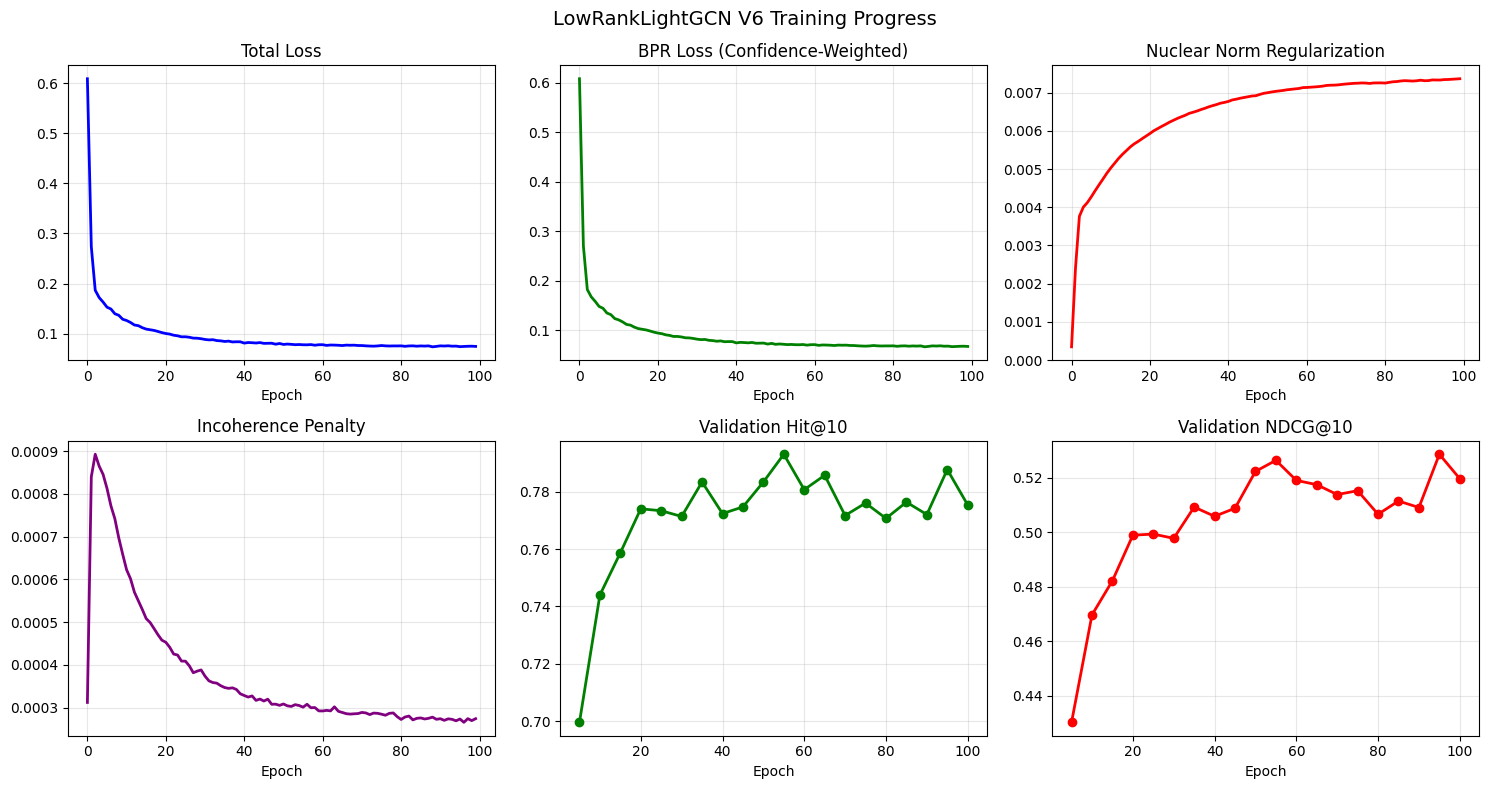

In [17]:
# Training curves
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Total Loss
axes[0, 0].plot(history['loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(alpha=0.3)

# BPR Loss
axes[0, 1].plot(history['bpr_loss'], 'g-', linewidth=2)
axes[0, 1].set_title('BPR Loss (Confidence-Weighted)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].grid(alpha=0.3)

# Nuclear Norm Loss
axes[0, 2].plot(history['nuclear_loss'], 'r-', linewidth=2)
axes[0, 2].set_title('Nuclear Norm Regularization')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].grid(alpha=0.3)

# Incoherence Loss
axes[1, 0].plot(history['incoh_loss'], 'purple', linewidth=2)
axes[1, 0].set_title('Incoherence Penalty')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].grid(alpha=0.3)

# Validation Hit@10
epochs_val = np.arange(5, EPOCHS+1, 5)[:len(history['val_hit@10'])]
axes[1, 1].plot(epochs_val, history['val_hit@10'], 'go-', linewidth=2)
axes[1, 1].set_title('Validation Hit@10')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].grid(alpha=0.3)

# Validation NDCG@10
axes[1, 2].plot(epochs_val, history['val_ndcg@10'], 'ro-', linewidth=2)
axes[1, 2].set_title('Validation NDCG@10')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].grid(alpha=0.3)

plt.suptitle('LowRankLightGCN V6 Training Progress', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Test Set 최종 평가 (1회만!)

In [18]:
# Load best model
model.load_state_dict(torch.load('best_lightgcn_v6.pt'))
model.eval()

print("=" * 70)
print("FINAL TEST SET EVALUATION (Single Run - No Peeking!)")
print("=" * 70)

# Test set evaluation
test_hit, test_ndcg = evaluate(model, test_users, test_items, sample_size=None)

print(f"\nTest Set Results:")
print(f"  Hit@10:  {test_hit:.4f}")
print(f"  NDCG@10: {test_ndcg:.4f}")

print(f"\nValidation Set Results (for reference):")
print(f"  Hit@10:  {best_val_hit:.4f}")
print(f"  NDCG@10: {best_val_ndcg:.4f}")

FINAL TEST SET EVALUATION (Single Run - No Peeking!)

Test Set Results:
  Hit@10:  0.7845
  NDCG@10: 0.5232

Validation Set Results (for reference):
  Hit@10:  0.7930
  NDCG@10: 0.5265


## 9. Threshold & O/X 추론

In [19]:
# Threshold tuning on validation set
with torch.no_grad():
    u_emb, i_emb = model(edge_index, edge_weight)

# Positive scores (validation)
val_pos_scores = (u_emb[val_users.to(device)] * i_emb[val_items.to(device)]).sum(dim=1).cpu().numpy()

# Negative scores (validation)
val_neg_scores = []
for user_idx in val_df['user_idx'].unique():
    n_pos = (val_df['user_idx'] == user_idx).sum()
    cands = user_neg_candidates[int(user_idx)]
    neg_items = np.random.choice(cands, size=min(n_pos, len(cands)), replace=False)
    
    u_t = torch.full((len(neg_items),), user_idx, dtype=torch.long, device=device)
    i_t = torch.LongTensor(neg_items).to(device)
    scores = (u_emb[u_t] * i_emb[i_t]).sum(dim=1).cpu().numpy()
    val_neg_scores.extend(scores)

all_scores = np.concatenate([val_pos_scores, np.array(val_neg_scores)])
all_labels = np.concatenate([np.ones(len(val_pos_scores)), np.zeros(len(val_neg_scores))])

print(f"Threshold tuning on {len(all_scores)} samples")

Threshold tuning on 15508 samples


In [20]:
# Find optimal threshold
thresholds = np.percentile(all_scores, [30, 40, 50, 60, 70, 80, 90])

print("Threshold Tuning:")
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 50)

best_prec, best_th, best_f1 = 0, 0, 0
for th in thresholds:
    preds = (all_scores >= th).astype(int)
    tp = ((preds == 1) & (all_labels == 1)).sum()
    fp = ((preds == 1) & (all_labels == 0)).sum()
    fn = ((preds == 0) & (all_labels == 1)).sum()
    
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    print(f"{th:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")
    
    if prec >= 0.6 and prec > best_prec:
        best_prec, best_th, best_f1 = prec, th, f1
    elif best_prec < 0.6 and f1 > best_f1:
        best_f1, best_th, best_prec = f1, th, prec

print("-" * 50)
print(f"Selected Threshold: {best_th:.4f} (Precision: {best_prec:.4f})")

Threshold Tuning:
Threshold    Precision    Recall       F1          
--------------------------------------------------
-0.1197      0.6687       0.9362       0.7802      
0.2697       0.7525       0.9030       0.8209      
1.0291       0.8423       0.8423       0.8423      
1.9064       0.9020       0.7216       0.8017      
2.7549       0.9353       0.5613       0.7015      
3.6755       0.9594       0.3838       0.5483      
4.8029       0.9749       0.1950       0.3250      
--------------------------------------------------
Selected Threshold: 4.8029 (Precision: 0.9749)


In [21]:
def predict_ox(test_pairs_df):
    results = []
    
    known_mask = test_pairs_df['user'].isin(user2idx) & test_pairs_df['item'].isin(item2idx)
    known_df = test_pairs_df[known_mask]
    unknown_df = test_pairs_df[~known_mask]
    
    if len(known_df) > 0:
        u_idx = torch.LongTensor([user2idx[u] for u in known_df['user']]).to(device)
        i_idx = torch.LongTensor([item2idx[i] for i in known_df['item']]).to(device)
        
        with torch.no_grad():
            scores = (u_emb[u_idx] * i_emb[i_idx]).sum(dim=1).cpu().numpy()
        
        for (_, row), score in zip(known_df.iterrows(), scores):
            results.append({
                'user': row['user'], 'item': row['item'],
                'recommend': 'O' if score >= best_th else 'X'
            })
    
    for _, row in unknown_df.iterrows():
        results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
    
    return pd.DataFrame(results)

# Test on validation set
preds = predict_ox(val_df[['user', 'item']])
o_ratio = (preds['recommend'] == 'O').mean()
print(f"\nO ratio on validation: {100*o_ratio:.1f}%")
print(preds.head(10).to_string(index=False))


O ratio on validation: 19.5%
 user  item recommend
    1    32         O
    1  1213         X
    1    47         O
    1  5418         X
    1  2959         O
    1  2542         X
    1  1221         O
    1  6365         X
    1   527         O
    2    52         X


## 10. 최종 결과 요약

In [22]:
print("=" * 70)
print("LightGCN V6 - Low-Rank Regularized GNN Final Summary")
print("=" * 70)

print(f"\nLow-Rank Theory Enhancements (from textbook):")
print(f"  1. SVD-based Initialization (Chapter 4.2)")
print(f"  2. Nuclear Norm Regularization (Chapter 4.3): λ={LAMBDA_NUCLEAR}")
print(f"  3. Incoherence Penalty (Chapter 4.4.3): λ={LAMBDA_INCOH}")
print(f"  4. Confidence-Weighted BPR (Chapter 4.4.5)")

print(f"\nModel Configuration:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nData Split:")
print(f"  Train: {len(train_df):,} ({100*len(train_df)/len(positive_df):.1f}%)")
print(f"  Valid: {len(val_df):,} ({100*len(val_df)/len(positive_df):.1f}%)")
print(f"  Test:  {len(test_df):,} ({100*len(test_df)/len(positive_df):.1f}%)")

print(f"\nPerformance:")
print(f"  Validation: Hit@10={best_val_hit:.4f}, NDCG@10={best_val_ndcg:.4f}")
print(f"  Test:       Hit@10={test_hit:.4f}, NDCG@10={test_ndcg:.4f}")
print(f"  Precision:  {best_prec:.4f}")
print(f"  O ratio:    {100*o_ratio:.1f}%")

print(f"\nV5 (In-batch Neg) → V6 (Low-Rank Reg) Comparison:")
print(f"  Note: V5 used 80/20 split, V6 uses 70/15/15 split")
print(f"  V5 Val Hit@10:  ~0.78 (on 80/20 split)")
print(f"  V6 Val Hit@10:  {best_val_hit:.4f}")
print(f"  V6 Test Hit@10: {test_hit:.4f} (NEW - unbiased estimate)")

LightGCN V6 - Low-Rank Regularized GNN Final Summary

Low-Rank Theory Enhancements (from textbook):
  1. SVD-based Initialization (Chapter 4.2)
  2. Nuclear Norm Regularization (Chapter 4.3): λ=1e-06
  3. Incoherence Penalty (Chapter 4.4.3): λ=0.001
  4. Confidence-Weighted BPR (Chapter 4.4.5)

Model Configuration:
  emb_dim: 32
  n_layers: 1
  Parameters: 351,648

Data Split:
  Train: 35,985 (69.4%)
  Valid: 7,754 (15.0%)
  Test:  8,091 (15.6%)

Performance:
  Validation: Hit@10=0.7930, NDCG@10=0.5265
  Test:       Hit@10=0.7845, NDCG@10=0.5232
  Precision:  0.9749
  O ratio:    19.5%

V5 (In-batch Neg) → V6 (Low-Rank Reg) Comparison:
  Note: V5 used 80/20 split, V6 uses 70/15/15 split
  V5 Val Hit@10:  ~0.78 (on 80/20 split)
  V6 Val Hit@10:  0.7930
  V6 Test Hit@10: 0.7845 (NEW - unbiased estimate)


In [23]:
# Ready for final test inference
# final_test_df = pd.read_csv('../data/test.csv')
# final_preds = predict_ox(final_test_df)
# final_preds.to_csv('predictions_v6.csv', index=False)

print("Final test inference ready.")
print("Uncomment above code when test.csv is provided.")

Final test inference ready.
Uncomment above code when test.csv is provided.
